In [1]:
from qutip import *
from qutip.qip.operations import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from random import random 
%matplotlib inline

In [2]:
def solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = False):
    tau_m = 3e-3
    w = 200
    H0 = -1j*etaOmega/2 *np.exp(1j*phi) * \
        tensor(sigmap(), create(Nmax))
    def H0_coeff(t, args):
        return np.exp(-1j*delta*np.sin(w*t)*t)

    H1 = 1j*etaOmega/2 *np.exp(-1j*phi) * \
        tensor(sigmam(), destroy(Nmax))
    def H1_coeff(t, args):
        return np.exp(1j*delta*np.sin(w*t)*t)

    H = [[H0, H0_coeff], [H1, H1_coeff]]

    c_ops = [tensor(qeye(2), np.sqrt(1/tau_m)*create(Nmax)*destroy(Nmax))]
    #c_ops = []
    if waiton:
        output = mesolve(tensor(qeye(2),qeye(Nmax)), s_init, t_list, c_ops, [])
    else:
        output = mesolve(H, s_init, t_list, c_ops, [])
    
    '''sz = []
    for i in range(len(output.states)):
        sz.append((output.states[i].ptrace(0)*sigmaz()).tr())
    plt.plot(t_list, sz)'''
    
    return output

In [3]:
def SpinEcho(tau):  
    Nmax = 10
    nth = 0.0
    s0 = tensor(ket2dm(basis(2,1)),thermal_dm(Nmax, nth))
    #s0 = tensor(ket2dm(basis(2,1)),coherent_dm(Nmax, 2))
    
    t0 = 0.1e-3 # ms, pi time
    etaOmega = np.pi/t0/np.sqrt(1+nth)
    delta = 1e3
    phi = 0
    
    # First step: pi/2 rotation
    t_start = 0
    t_stop = t0/2 #pi/2
    N_sample = 100

    s_init = s0
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = False)

    s1 = output.states[-1]

    # Second step: wait
    if tau == 0:
        s2 = s1
    else:    
        t_start = t_stop
        t_stop = t_start + tau
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s1

        output = solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = True)
        s2 = output.states[-1]

    # Third step: pi rotation
    t_start = t_stop
    t_stop = t_start + t0
    N_sample = 100
    t_list = np.linspace(t_start, t_stop, N_sample)
    s_init = s2

    output = solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = False)

    s3 = output.states[-1]

    # Fourth step: wait
    if tau == 0:
        s4 = s3
    else:  
        t_start = t_stop
        t_stop = t_start + tau
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s3

        output = solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = True)
        s4 = output.states[-1]

    # Fifth step: pi/2 rotation
    t_start = t_stop
    t_stop = t_start + t0/2 #pi/2
    N_sample = 100

    s_init = s4
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = False)

    s5 = output.states[-1].ptrace(0)
    return (s5*sigmaz()).tr()
    #s5 = output.states[-1]
    #return [s0, s1, s2, s3, s4, s5]

def scan_wait_time():
    tau_list = np.linspace(0,10e-3,101)
    probs = []
    for tau in tau_list:
        probs.append((SpinEcho(tau)+1)/2)
         
    plt.figure()
    plt.plot(tau_list, probs, 'b-', label = 'exp', )
    plt.axhline(y = 0.5*(1-1/np.exp(1)), label = '1/e', color='r', linestyle='-')
    plt.axhline(y = 0.5, label = 'y = 0.5', color='g', linestyle='--')
    plt.ylim([-0.1,1.1])
    plt.legend()

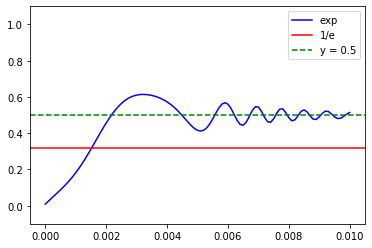

In [4]:
scan_wait_time()

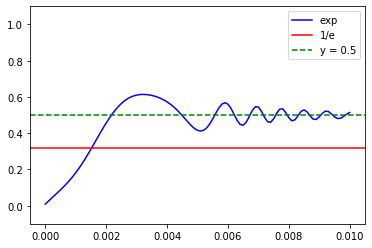

In [310]:
scan_wait_time()

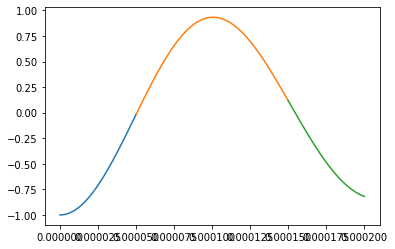

In [271]:
tau = 0
states = SpinEcho(tau)

In [272]:
print('z0=',(states[0].ptrace(0)*sigmaz()).tr())
print('z1=',(states[1].ptrace(0)*sigmaz()).tr())
print('z2=',(states[2].ptrace(0)*sigmaz()).tr())
print('z3=',(states[3].ptrace(0)*sigmaz()).tr())
print('z4=',(states[4].ptrace(0)*sigmaz()).tr())
print('z5=',(states[5].ptrace(0)*sigmaz()).tr())

print('y0=',(states[0].ptrace(0)*sigmay()).tr())
print('y1=',(states[1].ptrace(0)*sigmay()).tr())
print('y2=',(states[2].ptrace(0)*sigmay()).tr())
print('y3=',(states[3].ptrace(0)*sigmay()).tr())
print('y4=',(states[4].ptrace(0)*sigmay()).tr())
print('y5=',(states[5].ptrace(0)*sigmay()).tr())

print('x0=',(states[0].ptrace(0)*sigmax()).tr())
print('x1=',(states[1].ptrace(0)*sigmax()).tr())
print('x2=',(states[2].ptrace(0)*sigmax()).tr())
print('x3=',(states[3].ptrace(0)*sigmax()).tr())
print('x4=',(states[4].ptrace(0)*sigmax()).tr())
print('x5=',(states[5].ptrace(0)*sigmax()).tr())

adag = create(20)
a = destroy(20)
print('n0=',(states[0].ptrace(1)*adag*a).tr())
print('n1=',(states[1].ptrace(1)*adag*a).tr())
print('n2=',(states[2].ptrace(1)*adag*a).tr())
print('n3=',(states[3].ptrace(1)*adag*a).tr())
print('n4=',(states[4].ptrace(1)*adag*a).tr())
print('n5=',(states[5].ptrace(1)*adag*a).tr())

z0= -0.9999999999996815
z1= -0.0162319095323733
z2= -0.0162319095323733
z3= 0.11546302285438714
z4= 0.11546302285438714
z5= -0.8188464651943673
y0= 0.0
y1= 0.0
y2= 0.0
y3= 0.0
y4= 0.0
y5= 0.0
x0= 0.0
x1= 0.0
x2= 0.0
x3= 0.0
x4= 0.0
x5= 0.0
n0= 0.09999999999614456
n1= 0.5918840452297989
n2= 0.5918840452297989
n3= 0.6577315114231792
n4= 0.6577315114231792
n5= 0.190576767398802


In [246]:
(thermal_dm(10, 0)*adag*a).tr()

0.0

In [251]:
(states[1].ptrace(1)*adag*a).tr()

0.5000024781010941

In [ ]:
tau = 1e-3
states = SpinEcho(tau)

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 0

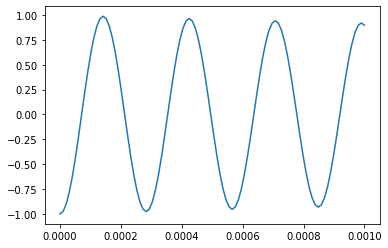

In [303]:
nth = 1
s_init = tensor(ket2dm(basis(2,1)),thermal_dm(10, 0.0))
Nmax = 10
t0 = 0.1e-3
t_start = 0
t_stop = 10*t0 
N_sample = 100
t_list = np.linspace(t_start, t_stop, N_sample)
etaOmega = np.pi/t0/np.sqrt(1+nth)
delta = 0
phi = 0
solve(s_init, t_list, t0, etaOmega, delta, phi, Nmax, waiton = False)